# Born Again Training: 
## Does re-labeling training/validation positives with model predictions in first round of training reduce overfitting to positives in upsampled batches in second round of training? 
Relevant: https://arxiv.org/pdf/1805.04770.pdf
## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data</a></li>
    <li><a href=#2>Train Model</a></li>
    <li><a href=#3>Performance and Interpretation</a></li>
    <li><a href=#4>Relabel Training/Validation Positives</a></li>  
    <li><a href=#5>Retrain the model from early stoppping phase</a></li>
    <li><a href=#6>Performance and Interpretation on Round 2 </a></li>
    <li><a href=#9>Conclusions</a></li>    
</ol>

In [6]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

#housekeeping
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Inputs <a name='1'>
<a href=#outline>Home</a>

Seqdataloader was used to generate genome-wide regression labels for the SPI TF Chip-seq dataset (see Tutorial 5), yielding these files: 
```
SPI1.train.regression.hdf5
SPI1.valid.regression.hdf5
SPI1.test.regression.hdf5
```
Set of bins with non-zero coverage values: 

In [7]:
from seqdataloader import * 

In [8]:
train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"train.positives.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"valid.positives.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"test.positives.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_regression'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
got peak subset for chrom:chr9 for task:SPI1
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
got peak subset for chrom:chr7 for task:SPI1
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
got peak subset for chrom:chr3 for task:SPI1
got peak subset for chrom:chr5 for task:SPI1
finished chromosome:chr9 for task:SPI1
finished chromosome:chr7 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
finished chromosome:chr5 for task:SPI1
got peak subset for chrom:chr10 for task:SPI1
finished chromosome:chr3 for task:SPI1
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
got peak subset for chrom:chr8 for task:SPI1
finished chromosome:chr10 for task:SPI1
pre-allocated df for chrom:chr6with dimensions:(

## Performance of SPI1 regression model from tutorial 5 <a name='1'>
<a href=#outline>Home</a>

In [9]:
from dragonn.generators import * 

Using TensorFlow backend.


In [58]:
from keras.models import load_model
#Start at best epoch from early stopping 
spi1_regression_model=load_model('SPI1.regression.model.hdf5')

## Performance and Interpretation<a name='3'>
<a href=#outline>Home</a>

In [59]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 351s 58ms/step


In [61]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.48666784], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.5009449436825775, pvalue=0.0)


In [63]:
import matplotlib.pyplot as plt
#normalize the truth values for more direct comparison 
spi1_test_regression_truth_normed=(spi1_test_regression_truth['SPI1']-min(spi1_test_regression_truth['SPI1']))/(max(spi1_test_regression_truth['SPI1'])-min(spi1_test_regression_truth['SPI1']))

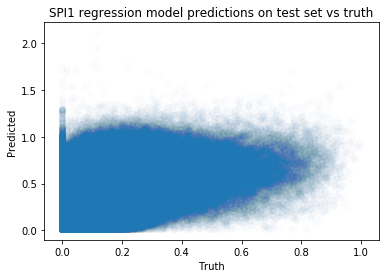

In [64]:
plt.scatter(spi1_test_regression_truth_normed, spi1_test_regression_predictions, alpha=0.01)
plt.xlabel("Truth (normalized)")
plt.ylabel("Predicted")
plt.title("SPI1 regression model predictions on test set vs truth")
plt.show()

In [73]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence (>0.9)
#get the true positive predictions 
true_pos=spi1_test_regression_truth[(spi1_test_regression_truth.values*spi1_test_regression_predictions)>2]
true_pos.shape

(16530, 1)

In [74]:
true_pos.sort_values(by="SPI1").tail()

SPI1
CHR   START     END                
chr19 38405150  38406150   5.429259
chr2  181198950 181199950  5.435546
chr19 38405200  38406200   5.438120
      50918600  50919600   5.477831
      50918650  50919650   5.497302

In [75]:
from dragonn.utils import one_hot_from_bed
deep_lift_input=one_hot_from_bed([i for i in true_pos.index],"/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa")
deep_lift_input.shape

(16530, 1, 1000, 4)

In [76]:
from dragonn.tutorial_utils import deeplift 

In [77]:
deep_lift_scores=deeplift(spi1_regression_model,deep_lift_input,target_layer_idx=-1)

In [78]:
from dragonn.tutorial_utils import  plot_seq_importance

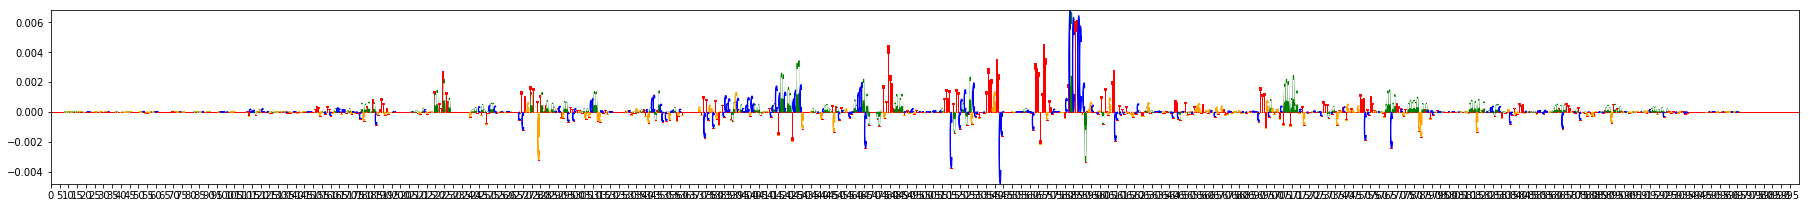

In [79]:
plot_seq_importance(deep_lift_scores[0],deep_lift_input[0])

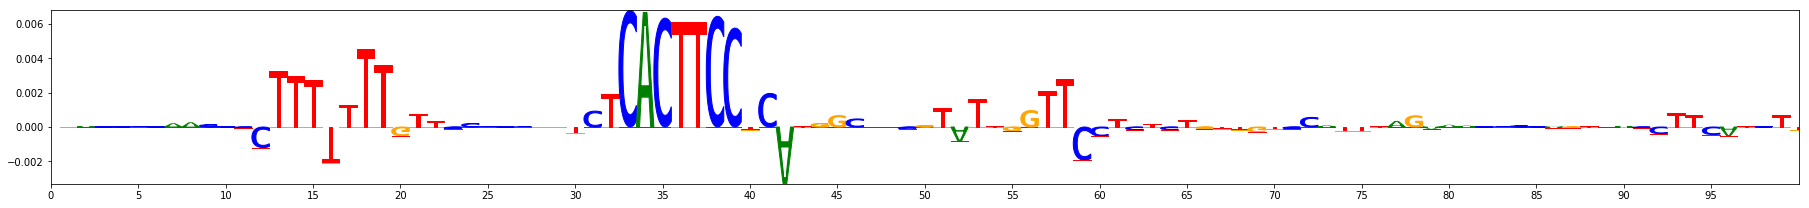

In [82]:
plot_seq_importance(deep_lift_scores[0].squeeze()[550:650],deep_lift_input[0].squeeze()[550:650])

In [83]:
#get the model predictions on the positives in train set (needed for relabeling)
pos_train_predict_gen=DataGenerator("SPI1.train.positives.regression.hdf5", "/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample=False,add_revcomp=False, batch_size=1000)
pos_train_predictions=spi1_regression_model.predict_generator(pos_train_predict_gen,
                                              max_queue_size=5000, 
                                              workers=50, 
                                              use_multiprocessing=True, 
                                              verbose=1)

139/139 [==============================] - 29s 206ms/step


In [84]:
#get the model predictions on the validation set (needed for relabeling)
pos_valid_predict_gen=DataGenerator("SPI1.valid.positives.regression.hdf5", "/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample=False,add_revcomp=False, batch_size=1000)
pos_valid_predictions=spi1_regression_model.predict_generator(pos_valid_predict_gen,
                                              max_queue_size=5000, 
                                              workers=50, 
                                              use_multiprocessing=True, 
                                              verbose=1)

25/25 [==============================] - 21s 840ms/step


In [85]:
#Store the  predictions 
import h5py 
predictions=h5py.File("predictions.hdf5",'w')
predictions.create_dataset("pos_valid",data=pos_valid_predictions)
predictions.create_dataset("pos_train",data=pos_train_predictions)
predictions.close() 

## Relabel training/validation positives <a name='5'>
<a href=#outline>Home</a>

In [86]:
import pandas as pd 
train_set=pd.read_hdf("SPI1.train.regression.hdf5",index_col=[0,1,2])
validation_set=pd.read_hdf("SPI1.valid.regression.hdf5",index_col=[0,1,2])

In [87]:
train_set_pos=pd.read_hdf("SPI1.train.positives.regression.hdf5",index_col=[0,1,2])
validation_set_pos=pd.read_hdf("SPI1.valid.positives.regression.hdf5",index_col=[0,1,2])

In [88]:
#0.1 was the minimum value observed in a positive bin 
pos_train_predictions[pos_train_predictions<0.1]=0.1
pos_valid_predictions[pos_valid_predictions<0.1]=0.1

In [89]:
train_set.shape


(49694107, 1)

In [90]:
pos_train_predictions.shape

(138395, 1)

In [91]:
#the dataframe size is not an even multiple of batch size, so we truncate some of the trailing values
pos_train_index=train_set_pos.index 
pos_valid_index=validation_set_pos.index

In [92]:
pos_train_index.shape

(138395,)

In [93]:
pos_train_predictions=pd.DataFrame(data=pos_train_predictions,index=pos_train_index,columns=['SPI1'])
pos_valid_predictions=pd.DataFrame(data=pos_valid_predictions,index=pos_valid_index,columns=['SPI1'])

In [94]:
#update the positive values in place 
train_set.update(pos_train_predictions)
validation_set.update(pos_valid_predictions)

In [95]:
#Store the updated training & validation labels to hdf5 
train_set.to_hdf("SPI1.train.relabeled.hdf5",key='data',mode='w',format='table')

In [96]:
validation_set.to_hdf("SPI1.valid.relabeled.hdf5",key='data',mode='w',format='table')

## Continue training model starting from early stopping state with relabeled set of labels <a name='6'>
<a href=#outline>Home</a>

In [97]:
#create the generator for keras training. Guarantee 30% positives in each batch 
train_gen2=DataGenerator("SPI1.train.relabeled.hdf5","/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample_ratio=0.3, upsample_thresh=0.1)
#create the generator for keras validation. Guarantee 30% positives in each batch 
valid_gen2=DataGenerator("SPI1.valid.relabeled.hdf5","/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample_ratio=0.3, upsample_thresh=0.1)
#create test set generator for prediction 
test_gen2=DataGenerator("SPI1.test.regression.hdf5", "/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",upsample=False,add_revcomp=False, batch_size=1000)

In [98]:
#Train the CTCF model 
## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history2=spi1_regression_model.fit_generator(train_gen2,
                                 validation_data=valid_gen2,
                                 steps_per_epoch=10000,
                                 validation_steps=5000,
                                 epochs=10,
                                 verbose=1,
                                 use_multiprocessing=True,
                                 workers=50,
                                 max_queue_size=100,
                                 callbacks=[History()])

Epoch 1/10
10000/10000 [==============================] - 195s 19ms/step - loss: 0.1119 - val_loss: 0.1120
Epoch 2/10
10000/10000 [==============================] - 142s 14ms/step - loss: 0.1113 - val_loss: 0.1128
Epoch 3/10
10000/10000 [==============================] - 142s 14ms/step - loss: 0.1110 - val_loss: 0.1118
Epoch 4/10
10000/10000 [==============================] - 141s 14ms/step - loss: 0.1113 - val_loss: 0.1093
Epoch 5/10
10000/10000 [==============================] - 142s 14ms/step - loss: 0.1108 - val_loss: 0.1095
Epoch 6/10
10000/10000 [==============================] - 143s 14ms/step - loss: 0.1099 - val_loss: 0.1132
Epoch 7/10
10000/10000 [==============================] - 142s 14ms/step - loss: 0.1107 - val_loss: 0.1128
Epoch 8/10
10000/10000 [==============================] - 139s 14ms/step - loss: 0.1109 - val_loss: 0.1124
Epoch 9/10
10000/10000 [==============================] - 139s 14ms/step - loss: 0.1095 - val_loss: 0.1134
Epoch 10/10
10000/10000 [============

In [99]:
loss2=pd.DataFrame(history2.history)
loss2['epoch']=list(loss2.index)


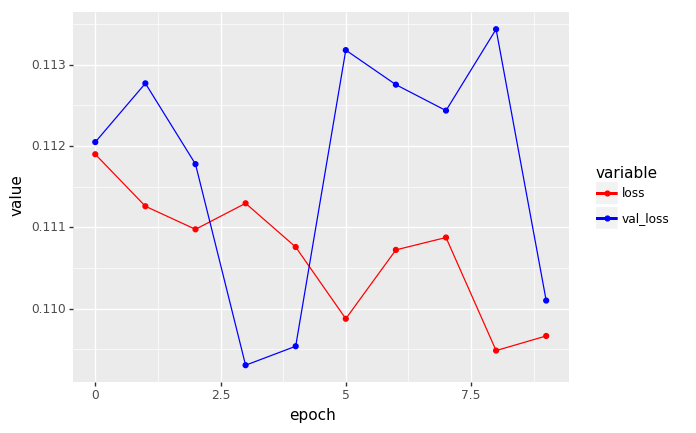

<ggplot: (-9223363278918186524)>

In [100]:
#Plot the loss curves 
from plotnine import *
subset2 = pd.melt(loss2, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
p2 = ggplot(subset2, aes(x='epoch', y='value', color='variable'))
(p2 + geom_line()
   + geom_point()
   + scale_color_manual(['r', 'b'])
)

## Performance and Interpretation on Round 2 <a name='7'>
<a href=#outline>Home</a>

In [101]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions2=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 359s 59ms/step


In [102]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions2)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions2)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.49390113], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.5078938372975801, pvalue=0.0)


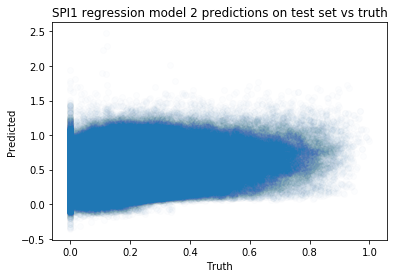

In [105]:
plt.scatter(spi1_test_regression_truth_normed, spi1_test_regression_predictions2, alpha=0.01)
plt.xlabel("Truth")
plt.ylabel("Predicted")
plt.title("SPI1 regression model 2 predictions on test set vs truth")
plt.show()

## Conclusions<a name='8'>
<a href=#outline>Home</a>